<a href="https://colab.research.google.com/github/bbc/apprenticeship-covid-hack/blob/main/notebooks/jh_COVID_diagnosis_hackathon_Group1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 diagnosis using symptoms

[Prateek Gupta](https://www.pgupta.info) 

2020-05-20

**Abstract:** This notebook is a tutorial on building a typical machine learning classifier. 
The process of doing so spans steps ranging from data wrangling to model selection. 
With the help of each of these steps we hope to make the reader familiar with challenges involved in building a machine learning system. 

# Question

In this hackathon, we want to build a machine learning model to predict COVID-19 infections from symptoms.
It has several applications, for example, triaging patients to be attended to by a doctor or nurse, recommending self-isolation through contact tracing apps. 

Zoabi et al. [[1]](https://www.nature.com/articles/s41746-020-00372-6) builds a decision tree classifier using the publicly available data reported by the Israeli Ministry of Health.
The paper itself dicsusses the various challenges encountered in deploying such a model. 
It is encouraged to read the paper and learn the challeges and ways to overcome them. 

However, in this hackathon, we will use their dataset and make the participant familiar with a typical pipeline of building a machine learning system.

[1] [Zoabi, Y., Deri-Rozov, S. & Shomron, N. Machine learning-based prediction of COVID-19 diagnosis based on symptoms. npj Digit. Med. 4, 3 (2021).]((https://www.nature.com/articles/s41746-020-00372-6))


# Setup the workspace

We will clone their Git repository to to use their dataset

In [193]:
!git clone https://github.com/nshomron/covidpred.git

fatal: destination path 'covidpred' already exists and is not an empty directory.


In [194]:
!pip install shap

In [195]:
import pandas as pd
import math
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import xgboost as xgb 
import shap

from pylab import rcParams
import seaborn as sb
from scipy.stats.stats import kendalltau

plt.rcParams["figure.figsize"] = (20, 5)

shap.initjs()

seed=909

# Data 

Let's check how the data looks like and how various features are encoded. 

In [196]:
#Load second dataset

# from zipfile import ZipFile

# zip_file = ZipFile('covidpred/data/corona_tested_individuals_ver_0083.english.csv.zip')

# df = pd.read_csv(zip_file.open("corona_tested_individuals_ver_0083.english.csv"))

#Remove NaN from 2nd dataset
# df = df.dropna(axis=0)

In [197]:
#Original Dataset
df = pd.read_csv('covidpred/data/corona_tested_individuals_ver_006.english.csv.zip')

Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.


Great! These are the features used in the paper for their prediction task. The authors also list these features in the [README.md of their Github repo](https://github.com/nshomron/covidpred). 

Pandas read columns as string, so we need to convert them to the proper format before we can operate on it.

In [198]:
df['test_date'] = pd.to_datetime(df['test_date'])

In [199]:
print("Start date:", min(df['test_date']))
print("End date:", max(df['test_date']))

n_days = (max(df['test_date']) - min(df['test_date'])).days
print("# of days: ", n_days)

n_obs =  df.shape[0]
print("# of observations:", df.shape[0])
print("# of features:", df.shape[1])

pos_cases = sum(df['corona_result'] == "positive")
print("# of positively diagnosed cases: {0} ({1: 2.2f}%)".format(pos_cases, 100*pos_cases / n_obs))

neg_cases = sum(df['corona_result'] == "negative")
print("# of negatively diagnosed cases: {0} ({1: 2.2f}%)".format(neg_cases, 100 * neg_cases / n_obs))

other_cases = sum(df['corona_result'] == "other") # possibly not confirmed
print("# of other cases (possibly, not confirmed): {0} ({1: 2.2f}%)".format(other_cases, 100 * other_cases / n_obs))

Start date: 2020-03-11 00:00:00
End date: 2020-04-30 00:00:00
# of days:  50
# of observations: 278848
# of features: 10
# of positively diagnosed cases: 14729 ( 5.28%)
# of negatively diagnosed cases: 260227 ( 93.32%)
# of other cases (possibly, not confirmed): 3892 ( 1.40%)


Since we do not have any information on what happened to "other" cases, we will exclude them from our exercise. 



In [200]:
df = df[df['corona_result'].isin(['positive', 'negative'])]

To build out predictor, we will be splitting our dataset into **training,  validation, and test sets**. 
A model is trained on the training dataset while the hyperparameters are tuned on the validation dataset. 
Finally, a test dataset is used to report final model's performance metrics. 

Since we have a time dependent dataset we will split our training and test dataset based on time. 
Thus, we find the date before which 60% of observations are present, and use that as our training dataset.
We will use next 20% of the dataset as our validation dataset, and finally, the remaining 20% will be used as a test dataset. 
Thus, we use 60-20-20 split.

The authors use 63%-23% training-test split, and a further split of training into train-valid dataset using 80-20% split.
There is no prescribed formula on how to do this split. 



In [201]:
date_counts = df.groupby(['test_date']).count()['gender'] # take count of any column. They will all be same.
date_counts = date_counts.sort_index()
cum_counts = date_counts.cumsum()
cdf = cum_counts / n_obs



In [202]:
max_training_date = cdf[cdf < 0.60].index.max()
training_data = df[df['test_date'] <= max_training_date]

min_test_date = cdf[cdf > 0.80].index.min()
test_data = df[df['test_date'] >= min_test_date]

valid_data = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]
print("max_training_date:",max_training_date)
print("min_test_date:",min_test_date)
print("# of observations in training dataset", training_data.shape[0])
print("# of observations in validation dataset", valid_data.shape[0])
print("# of observations in test dataset", test_data.shape[0])

max_training_date: 2020-04-15 00:00:00
min_test_date: 2020-04-22 00:00:00
# of observations in training dataset 160717
# of observations in validation dataset 53172
# of observations in test dataset 61067


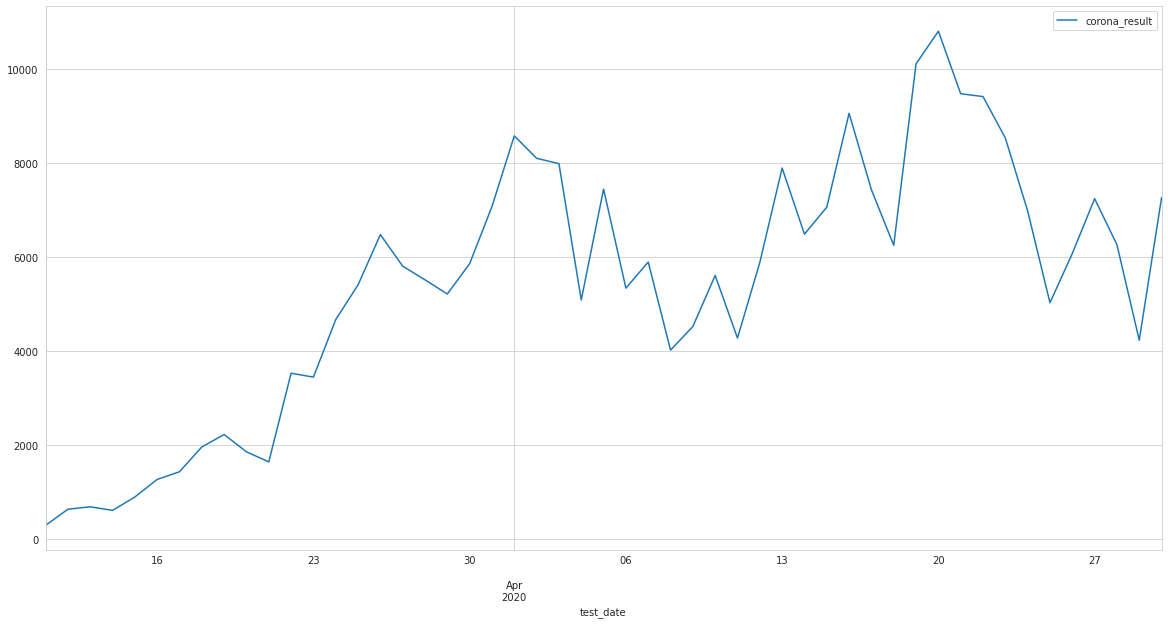

In [203]:
plt.rcParams["figure.figsize"] = (20, 10)
df_daily=df.groupby('test_date').count().reset_index()
df_daily.plot(x='test_date', y=['corona_result'],kind="line")
plt.show()


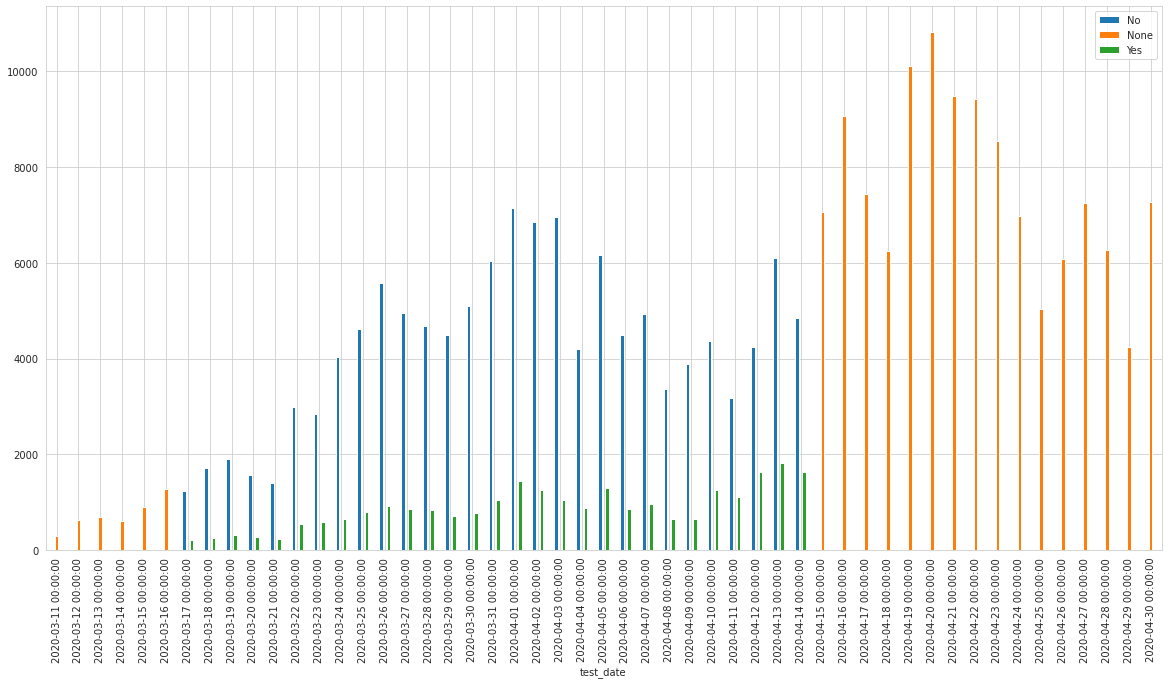

In [204]:
plt.rcParams["figure.figsize"] = (20, 10)

age_60_df = df[["test_date", "age_60_and_above"]]

tempdf = pd.get_dummies(age_60_df["age_60_and_above"])
age_60_df = pd.merge(
    left=age_60_df,
    right=tempdf,
    left_index=True,
    right_index=True,
)
age_60_df = age_60_df.drop(columns="age_60_and_above")
age_60_dates = age_60_df.groupby('test_date').sum().reset_index()

age_60_dates.set_index("test_date").plot.bar()

### Using a date split has issues with the "age_60_and_above" column - No "yes" in valid_data or test_data
Training data is selected from 15th April to 22nd April - this gives a selection of No, Yes and None

BUT: Test data is selected after and including the 22nd April where the 60 and above data is only None

AND: Validation data is selected from befor the 15th, again where the data is None

Do we ditch the feature OR impute???

### Let's roll with a standard train_test_split for now

In [205]:
def normalise(x):
  if type(x) == str:
    return int(x) if x != "None" else 2
  return x

In [206]:
symptoms = ["cough","fever","sore_throat","shortness_of_breath","head_ache"]
categorical = ["age_60_and_above","gender","test_indication"]

#Clean inconsitent datatypes within symptom columns
for col in symptoms:
  df.loc[:, col] = df[col].apply(normalise)

# X = df.drop(["test_date"],axis=1)
# y = X["corona_result"]

# #Split off training data and then spliut the remaining into validation and test
# training_data, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
# valid_data, test_data, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=42, stratify=y_rem)



In [207]:
# #Shuffle Split
def select_and_split_data(df, trainvalid_size=0.8):
  X = df.drop(["test_date"],axis=1)
  y = X["corona_result"]
  training_data, X_rem, y_train, y_rem = train_test_split(X, y, test_size=2*(1-trainvalid_size), random_state=seed, stratify=y)
  valid_data, test_data, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state=seed, stratify=y_rem) 
  return training_data, valid_data, test_data

training_data, valid_data, test_data = select_and_split_data(df,0.8)

In [208]:
#Original Split
# def select_and_split_data(df, trainvalid_size=0.8):
#   df['test_date'] = pd.to_datetime(df['test_date'])
#   df = df[df['corona_result'].isin(['positive', 'negative'])]
#   df = df[df['test_date'] >= '2020-3-22']


#   date_counts = df.groupby(['test_date']).count()['gender'] # take count of any column. They will all be same.
#   date_counts = date_counts.sort_index()
#   n_obs = df.shape[0]
#   cum_counts = date_counts.cumsum()
#   cdf = cum_counts / n_obs

#   max_training_date = cdf[cdf < 0.60].index.max()
#   training_data = df[df['test_date'] <= max_training_date]

#   min_test_date = cdf[cdf > 0.80].index.min()
#   test_data = df[df['test_date'] >= min_test_date]

#   valid_data = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]

#   return training_data, valid_data, test_data

# training_data, valid_data, test_data = select_and_split_data(df,0.8)

In [209]:
# Split on dates to exclude missing gender/age data
# Run this on the raw dataframe returned by pd.read_csv, include params for train/test split ratio (default: 80:20 split trainvalid/test & train/valid)
# def select_and_split_data(df, trainvalid_size=0.8):
#   df['test_date'] = pd.to_datetime(df['test_date'])
#   df = df[df['corona_result'].isin(['positive', 'negative'])]
  
#   date_counts = df.groupby(['test_date']).count()['gender'] # take count of any column. They will all be same.
#   date_counts = date_counts.sort_index()
#   n_obs = df.shape[0]
#   cum_counts = date_counts.cumsum()
#   cdf = cum_counts / n_obs

#   max_training_date = cdf[cdf < trainvalid_size*trainvalid_size].index.max()
#   training_data = df[df['test_date'] <= max_training_date]

#   min_test_date = cdf[cdf > trainvalid_size].index.min()
#   test_data = df[df['test_date'] >= min_test_date]

#   valid_data = df[(max_training_date < df['test_date']) & (df['test_date'] < min_test_date)]

#   return training_data, valid_data, test_data

# training_data, valid_data, test_data = select_and_split_data(df,0.8)

In [210]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# def normalise(x):
#   if type(x) == str:
#     if x in ['0', '1']:
#       return int(x)
#     elif x == 'None':
#       return None
#   return x


# # Normalise columns to conver strings to ints and 'None' to np.nan
# for col in training_data.columns:
#   training_data.loc[:, col] = training_data[col].apply(normalise)
#   valid_data.loc[:, col] = valid_data[col].apply(normalise)
#   test_data.loc[:, col] = test_data[col].apply(normalise)

# # Drop 'test_date' column and age column (TBC if we want to drop age)
# training_data.drop(['test_date', 'age_60_and_above'], axis=1,inplace=True)
# valid_data.drop(['test_date','age_60_and_above'], axis=1,inplace=True)
# test_data.drop(['test_date','age_60_and_above'], axis=1,inplace=True)

# lb_train = LabelBinarizer()
# lb_train.fit(training_data['corona_result'])

# # Train a pipeline to transform categorical variables with imputation of missing values
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan)),
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', categorical_transformer, [0])
#     ])

# preprocessor.fit(training_data.drop('corona_result',axis=1))



In [211]:
# def preprocess(data, encoder, lb):
#   """
#   Transforms `data` into format required for model building

#   Args:
#     data (pd.DataFrame): dataframe with columns `INPUT_FEAUTURES` and `TARGET_COLUMN`
#     encoder (sklearn.preprocessing.OneHotEncoder): A fitted OneHotEncoder to be used to transform `INPUT_FEATURES`
#     lb (sklearn.preprocessing.LabelBinarizer): A fitted LabelBinarizer to be used to transform `TARGET_COLUMN`
  
#   Returns:
#     model_input (np.array): each row is an observation, columns are one-hot encoded features of `INPUT_FEATURES`
#     model_target (np.array): 1D array with 1 where `TARGET_COLUMN` is "positive" and 0 otherwise.
#   """

#   model_target = lb.transform(data['corona_result']).flatten()
#   model_input = encoder.transform(data.drop('corona_result', axis=1))

#   return model_input, model_target

# X_train, y_train = preprocess(training_data, preprocessor, lb_train)
# X_valid, y_valid = preprocess(valid_data, preprocessor, lb_train)
# X_test, y_test = preprocess(test_data, preprocessor, lb_train)

# encoder = preprocessor
# lb = lb_train

**NOTE:**
It is **extremely important** that you do not use the test dataset in the model building phase. 
While building models, it is required to tune the hyperparameter, adjust assumptions, modify features, etc. 
This should be done on the validation dataset. 
After several such iterations on the validation dataset, you will pick a model with the best performace as your final model. 

A test dataset is used to measure the final model's performance, which is a proxy for how it will perform (or generalize) in real life. 
Thus, to have a proper measure of model's genearalization, test dataset should not be part of your model building process. 

# Exploratory Data Analysis

In this section, we will see the general statistics of features.
In doing so, we will encounter inconsistencies in the data and address them accordingly. 







In [212]:
# We want to predict 'corona_result'. 
# We will not use "test_date" as a feature. 
# So we narrow down the input features to this list 
INPUT_FEATURES = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
#INPUT_FEATURES = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'gender', 'test_indication']
TARGET_COLUMN = 'corona_result'

for col in INPUT_FEATURES:
  print("*"*25, f" {col} ", "*"*25)
  print(training_data[col].value_counts())

*************************  cough  *************************
0    139812
1     25026
2       135
Name: cough, dtype: int64
*************************  fever  *************************
0    152001
1     12836
2       136
Name: fever, dtype: int64
*************************  sore_throat  *************************
0    163845
1      1127
2         1
Name: sore_throat, dtype: int64
*************************  shortness_of_breath  *************************
0    164048
1       924
2         1
Name: shortness_of_breath, dtype: int64
*************************  head_ache  *************************
0    163521
1      1451
2         1
Name: head_ache, dtype: int64
*************************  age_60_and_above  *************************
None    75167
No      74546
Yes     15260
Name: age_60_and_above, dtype: int64
*************************  gender  *************************
female    77104
male      76316
None      11553
Name: gender, dtype: int64
*************************  test_indication  ************

## Group by Target Class and Visualise

In [213]:
df_features = df.drop("test_date",axis=1).copy()

#preprocess symptoms
for col in symptoms:
    df_features[col].replace('None', 0, inplace=True)
    df_features[col] = df_features[col].astype(np.uint8)
    #print("="*40)
    #print(df_features[col].value_counts())

#preprocess categorical columns
for col in categorical:
    tempdf = pd.get_dummies(df_features[col], prefix=col)
    df_features = pd.merge(
        left=df_features,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_features = df_features.drop(columns=col)
df_features = df_features.drop(columns=["age_60_and_above_No",
                                        "age_60_and_above_None",
                                        "gender_None",
                                        "test_indication_Abroad",
                                        "test_indication_Other"])

df_grouped = df_features.drop(["gender_male","gender_female"], axis=1).groupby(TARGET_COLUMN).sum()
df_grouped

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above_Yes,test_indication_Contact with confirmed
corona_result,,,,,,,
negative,35425.0,16254.0,366.0,385.0,148.0,23221.0,3160.0
positive,6650.0,5625.0,1528.0,1166.0,2237.0,2204.0,7318.0


In [214]:
df_gender = df_features[["gender_male","gender_female",TARGET_COLUMN]].groupby(TARGET_COLUMN).sum()
df_gender

,gender_male,gender_female
corona_result,,
negative,119851.0,122500.0
positive,7519.0,6041.0


## Visualisation: Features Grouped by Target Class

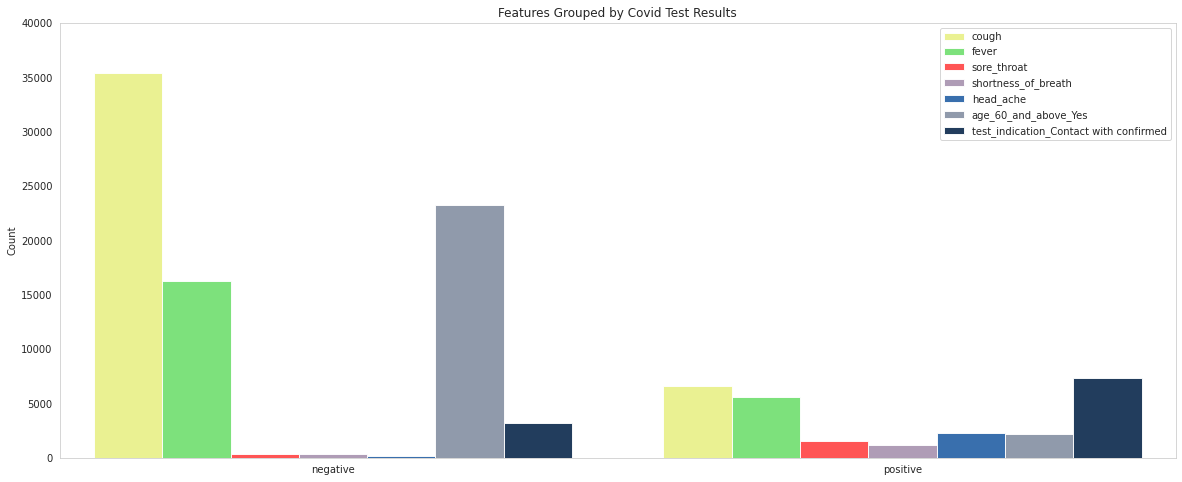

In [215]:

colour_palette = ["#E8F086","#6FDE6E","#FF4242","#A691AE","#235FA4", "#848FA2", "#0A284B"]
pos = list(range(len(df_grouped['cough'])))

#def plotBarChart(df, )
width = 0.12

fig, ax = plt.subplots(figsize=(20,8))

count=0
for col in df_grouped.columns:
  plt.bar([p + width*count for p in pos], df_grouped[col], width, alpha=0.9, color=colour_palette[count])
  count=count+1


# Setting the y axis label
ax.set_ylabel('Count')

# Setting the chart's title
ax.set_title('Features Grouped by Covid Test Results')

# Setting the position of the x ticks
ax.set_xticks([0.36,1.36])

# Setting the labels for the x ticks
ax.set_xticklabels(['negative','positive'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*len(df_grouped.columns))
plt.ylim([0, 40000] )

# Adding the legend and showing the plot
plt.legend(df_grouped.columns, loc='upper right')
plt.grid()
plt.show()

Notes:
*   Low recording of some less physically obvious symptoms for those recording a negative result. This could indicate a bias.
*   Cough and fever seem to good indicators
*   Contact with a confirmed case also strong







### Gender Grouped by Target Class

2 [0, 1]


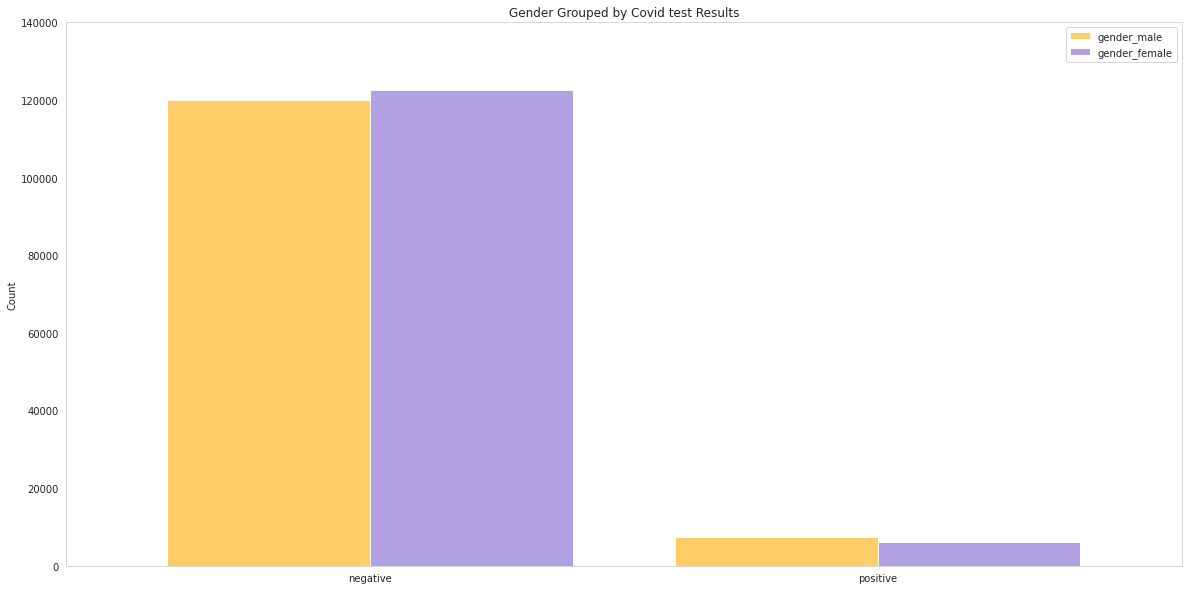

In [216]:

colour_palette = ["#FFC857","#A997DF"]
pos = list(range(len(df_gender['gender_female'])))
print(len(pos), pos)
width = 0.4

fig, ax = plt.subplots(figsize=(20,10))

count=0
for col in df_gender.columns:
  plt.bar([p + width*count for p in pos], 
          df_gender[col], width, alpha=0.9,color=colour_palette[count])
  count=count+1


# Setting the y axis label
ax.set_ylabel('Count')

# Setting the chart's title
ax.set_title('Gender Grouped by Covid test Results')

# Setting the position of the x ticks
ax.set_xticks([0.2,1.2])

# Setting the labels for the x ticks
ax.set_xticklabels(['negative','positive'])

# Setting the x-axis and y-axis limits
plt.xlim(min(pos)-width, max(pos)+width*len(df_gender.columns))
plt.ylim([0, 140000] )

# Adding the legend and showing the plot
plt.legend(df_gender.columns, loc='upper right')
plt.grid()
plt.show()

Notes:
*   There are more positive cases for males in spite of more females in the cohort




Here are the questions to guide you through the process of exploring data 

1.   Think about possible biases and limitations of this dataset
2.   What is the format of feature values? Are there any inconsistencies? If so, how would you make them cosistent?
3.   What is the statistics of these feature values? How many symptoms are reported or not?
4.   Which symptoms have a reporting bias, i.e., likely to be reported when the patient is COVID positive? 
5.   How will the symptoms with reporting bias affect the model’s performance?
6.   Visualization: Draw the bar graph of features grouped by the target class? 
7.   How does the bar graph of the symptoms with reporting bias looks like?
8.   Determine if we have a class imbalance in the dataset? If so, what do you reckon will be the downstream challenges in evaluating the model? How will you overcome those challenges?
9.   What does "None" value mean for feature? Should we include these features?

##Correlations & Heatmap

In [217]:
df_corr = df_features
#preprocess categorical columns

tempdf = pd.get_dummies(df_corr["corona_result"], prefix="corona_result")
df_corr = pd.merge(
    left=df_corr,
    right=tempdf,
    left_index=True,
    right_index=True,
)
df_corr = df_corr.drop(columns=["corona_result","corona_result_negative"])


In [218]:
correlations_df=df_corr
pearson = correlations_df.corr(method='pearson')

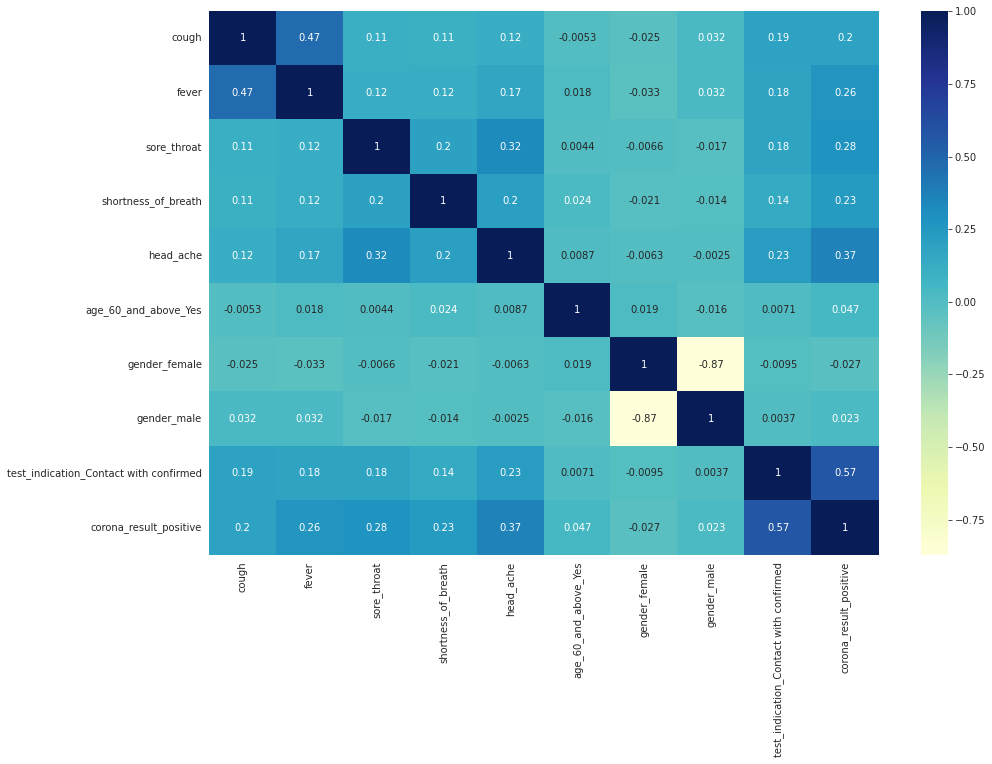

In [219]:
%matplotlib inline
rcParams['figure.figsize'] = 5,4
sb.set_style('whitegrid')

rcParams['figure.figsize'] = 15,10
sb.heatmap(pearson, 
           xticklabels=pearson.columns.values, 
           yticklabels=pearson.columns.values, 
           cmap="YlGnBu",
          annot=True)


**GOOD PRACTICE**: To make your plots accessible to everyone, it is always a good idea to use colorblind-friendly palette for your plots. Check out [this](https://medium.com/cafe-pixo/inclusive-color-palettes-for-the-web-bbfe8cf2410e) for such a palette.

# Feature Engineering

In this section, we will transform the features that models can operate upon. Note that this transformation doesn't have to be unique. 
It is very much dependent on the type of model you are building. 

Here is the list of questions to guide your feature engineering task 

1.   How will you represent the features in numerical format that can be accessible by model? 
2.   Are there any redundancies in your feature representation?
3.   How will you represent targets in a format accessible to the model?

Check out [`sklearn`'s preprocessing library](https://scikit-learn.org/stable/modules/preprocessing.html) for easy-to-use functions to do this. 

In [220]:
def preprocess(data, encoder, lb):
  """
  Transforms `data` into format required for model building

  Args:
    data (pd.DataFrame): dataframe with columns `INPUT_FEAUTURES` and `TARGET_COLUMN`
    encoder (sklearn.preprocessing.OneHotEncoder): A fitted OneHotEncoder to be used to transform `INPUT_FEATURES`
    lb (sklearn.preprocessing.LabelBinarizer): A fitted LabelBinarizer to be used to transform `TARGET_COLUMN`
  
  Returns:
    model_input (np.array): each row is an observation, columns are one-hot encoded features of `INPUT_FEATURES`
    model_target (np.array): 1D array with 1 where `TARGET_COLUMN` is "positive" and 0 otherwise.
  """

  x = encoder.transform(data[INPUT_FEATURES]).todense()
  y = lb.transform(data[TARGET_COLUMN]).flatten() 

  return x, y

lb = LabelBinarizer()
lb.fit(training_data['corona_result'])


encoder = OneHotEncoder()
encoder.fit(training_data[INPUT_FEATURES]) 


OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

# Model building

In this section, we will build various classifiers using `sklearn`. You do not have to restrict yourself to `sklearn`. Please feel free to use any other library.

**TRY:**  Try various classifiers that you have learned so far.
Here is the list of models to try :

*  Logistic Regssion: [User Guide](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). [API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
*   Decision Trees: [User Guide](https://scikit-learn.org/stable/modules/tree.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). You can head down in the User Guide to [other Tree algorithms](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) if you fancy. 
*   Categorical Naive Bayes.[User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#categorical-naive-bayes). [API](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB)
*   Linear Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis)
*   Quadratic Discriminant Analysis. [User Guide](https://scikit-learn.org/stable/modules/lda_qda.html#). [API](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis)
*   Support Vector Machines. [User Guide](https://scikit-learn.org/stable/modules/svm.html#classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
*   Nearest neighbors classification. [User Guide](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
*   Neural networks - Multi-layer Perceptron (MLP). [User Guide](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron). [API](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)



In [221]:
# X_train, Y_train = preprocess(training_data, encoder, lb)
# model = clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(3, 2), random_state=1, warm_start=False, max_iter=100)
# model.fit(X_train, Y_train)

# Evaluate Model

In this section, we will evaluate our model's performance on the validation dataset. 

Here are the list of questions to think about while deciding how to evaluate your model - 
*   Is accuracy the right metric to evaluate the model? Are inaccuracies correctly penalized in the accuracy metric?
*  Would you think that the cost of false negative is more than the false positive? Is it dependent on the application?
*  Which metric will minimize false negatives and false positives?
*   Which dataset should you chose to evaluate the model? Validation or Test?
What other metric is relevant in our context?  

For benchmarking everyone’s results we will stick to ROC AUC score as a metric. 
There are standard functions to compute these scores in `sklearn`, so we will use them. 
Specifically, we will be using [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) and [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html).


In [222]:
def plot_ROC(model, X, Y):
  # plot
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
  plot_roc_curve(model, X, Y, ax =ax, color="#2E4052")

  # formatting 
  ax.plot(np.arange(0,1, 0.01), np.arange(0, 1, 0.01), color="#2E4052", linestyle="-.") # reference line
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  _ = ax.set_title("Receiver Operating Characteristics", fontsize=15)

In [223]:
def evaluate(model, X, Y):
  """
  Returns the AUC-ROC for `model` as evaluated on (X, Y)

  Args:
    model (): Any model that has a function predict_proba and returns probability for each row in `X`.
    X (np.array): Input to the model containing feature values
    Y (np.array): 1D array containing true class i.e. 0 or 1
  
  Returns:
    (float): AUC ROC for the model
  """
  y_pred = model.predict_proba(X)[:, 1]
  return roc_auc_score(Y, y_pred)

  
  # For example - 
  # y_score = model.predict_proba(X) # (n_samples, n_clases) with each value being the probability of being in that class
  # return roc_auc_score(y_true=Y, y_score=y_score[:, 1])

# Hyperparameter Search

In this section we will be searching for the best parameters to build our models. 
This is where we will use our validation dataset. 




In [224]:
# from sklearn.model_selection import GridSearchCV

# parameter_space = {
#     'hidden_layer_sizes': [(6,3, 2), (100,2), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['adam'],
#     'alpha': [0.0001],
#     'learning_rate': ['constant'],
#     'random_state':[42]
# }

# clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=5)
# clf.fit(X_train, Y_train)

# # Best parameter set
# print('Best parameters found:\n', clf.best_params_)

# # All results
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Best parameters found:
#  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'random_state': 42, 'solver': 'adam'}

In [225]:
# from sklearn.model_selection import GridSearchCV
# dt=DecisionTreeClassifier()
# parameter_space = {
#     'criterion': ["gini","entropy"],
#     'max_depth': [2,5,10],
#     'min_samples_split': [3,5],
#     'min_samples_leaf': [3,4],
# }

# clf = GridSearchCV(dt, parameter_space, n_jobs=-1, cv=5)
# clf.fit(X_train, Y_train)

# # Best parameter set
# print('Best parameters found:\n', clf.best_params_)

# # All results
# means = clf.cv_results_['mean_test_score']
# stds = clf.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# Best parameters found:
#  {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'random_state': 42, 'solver': 'adam'}

In [226]:
# rfc = RandomForestClassifier(random_state=42)

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }
# CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_train, Y_train)

# # Best parameter set
# print('Best parameters found:\n', CV_rfc.best_params_)

# # All results
# means = CV_rfc.cv_results_['mean_test_score']
# stds = CV_rfc.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, CV_rfc.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

MODEL: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
AUC ROC score for the model (valid): 0.9047289224421108 

AUC ROC score for the model (test): 0.9097137039642644 



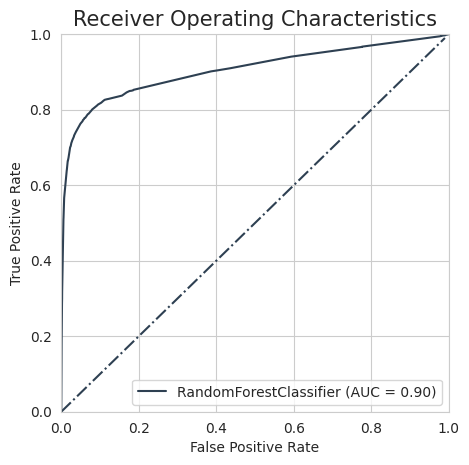

In [227]:
X_train, Y_train = preprocess(test_data, encoder, lb)

rfc = RandomForestClassifier(n_estimators=500,
                             max_features='auto',
                             max_depth=12,
                             criterion='entropy',
                             random_state=42)
rfc.fit(X_train, Y_train)
X_valid, Y_valid = preprocess(valid_data, encoder, lb)
X_test, Y_test = preprocess(test_data, encoder, lb)
y_score = rfc.predict_proba(X_valid) # (n_samples, n_classes) with each value being the probability of being in that class

print("MODEL:",rfc)
print("AUC ROC score for the model (valid):", evaluate(rfc, X_valid, Y_valid), "\n")
print("AUC ROC score for the model (test):", evaluate(rfc, X_test, Y_test), "\n")

plot_ROC(rfc, X_valid, Y_valid)

In [228]:
X_test.shape, X_valid.shape, Y_test.shape, Y_valid.shape

((54992, 24), (54991, 24), (54992,), (54991,))

MODEL: MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=100,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
AUC ROC score for the model (valid): 0.9077778923495432 

AUC ROC score for the model (test): 0.9067124422729188 



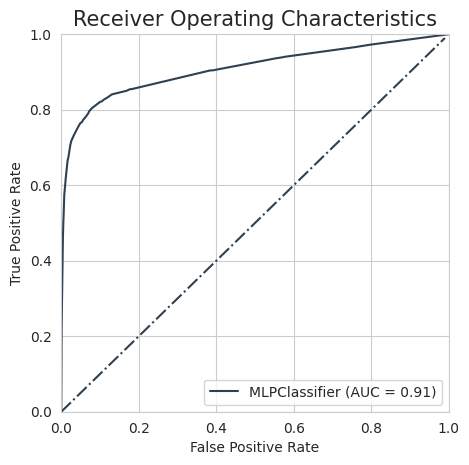

In [229]:
# model = clf = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(6, 3, 2), random_state=42,
#                             learning_rate='constant', activation='tanh', warm_start=True, max_iter=100)
model = clf = MLPClassifier(solver='adam', alpha=0.0001, hidden_layer_sizes=(200,), random_state=42,
                            learning_rate='constant', activation='tanh', warm_start=False, max_iter=100)
model.fit(X_train, Y_train)

X_valid, Y_valid = preprocess(valid_data, encoder, lb)
X_test, Y_test = preprocess(test_data, encoder, lb)
y_score = model.predict_proba(X_valid) # (n_samples, n_classes) with each value being the probability of being in that class

print("MODEL:",model)
print("AUC ROC score for the model (valid):", evaluate(model, X_valid, Y_valid), "\n")
print("AUC ROC score for the model (test):", evaluate(model, X_test, Y_test), "\n")
plot_ROC(model, X_valid, Y_valid)

In [230]:


# explain all the predictions in the test set
# explainer = shap.KernelExplainer(model.predict_proba, training_data.drop("corona_result", axis=1))
# shap_values = explainer.shap_values(X_valid)
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_valid)

LightGBM

In [231]:
# def preprocess_hack(data):
#   df_features = data.copy()

#   symptoms = ["cough","fever","sore_throat","shortness_of_breath","head_ache"]
#   categorical = ["age_60_and_above","gender","test_indication","corona_result"]

#   #preprocess symptoms - replace None with 0 and cast column as integer
#   for col in symptoms:
#       df_features[col].replace('None', 0, inplace=True)
#       df_features[col] = df_features[col].astype(np.uint8)

#   #preprocess categorical columns - OneHotEncode using get)dummies
#   for col in categorical:
#       tempdf = pd.get_dummies(df_features[col], prefix=col)
#       df_features = pd.merge(
#           left=df_features,
#           right=tempdf,
#           left_index=True,
#           right_index=True,
#       )
#       df_features = df_features.drop(columns=col)
#   df_features = df_features.drop(columns=["age_60_and_above_No","age_60_and_above_None",
#                                           "gender_None","gender_female",
#                                           "corona_result_negative",
#                                           "test_indication_Abroad",
#                                           "test_indication_Other"])
  
#   return df_features

# xgb_xtrain = preprocess_hack(training_data)
# xgb_ytrain = xgb_xtrain["corona_result_positive"]
# xgb_xtrain = xgb_xtrain.drop("corona_result_positive",axis=1)

# xgb_xtest = preprocess_hack(test_data)
# xgb_ytest = xgb_xtest["corona_result_positive"]
# xgb_xtest = xgb_xtest.drop("corona_result_positive",axis=1)

In [232]:
# from datetime import datetime 

# #X_test, Y_test = preprocess(test_data, encoder, lb)

# lgb_train_data=lgb.Dataset(xgb_xtrain,label=xgb_ytrain)

# #param = {'num_leaves':200, 'objective':'binary','max_depth':12,'learning_rate':.05,'max_bin':200}
# param = {
#     'num_leaves': 200,
#     'min_data_in_leaf': 4,
#     'feature_fraction': 0.2,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'learning_rate': 0.05,
#     'verbose': 1
# }
# param['metric'] = ['auc', 'binary_logloss']

# #training our model using light gbm
# num_round=603
# start=datetime.now()
# lgbm=lgb.train(param,lgb_train_data,num_round)
# stop=datetime.now()

In [233]:
# ypred2=lgbm.predict(xgb_xtest)
# #converting probabilities into 0 or 1
# # for i in range(len(ypred2)):
# #     if ypred2[i]>=.5:       # setting threshold to .5
# #        ypred2[i]=1
# #     else:  
# #        ypred2[i]=0

# auc_xgb =  roc_auc_score(xgb_ytest,ypred2)
# auc_xgb

In [234]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), dpi=100)
# plot_roc_curve(lgbm, X_valid, Y_valid, ax =ax, color="#2E4052")

# # formatting 
# ax.plot(np.arange(0,1, 0.01), np.arange(0, 1, 0.01), color="#2E4052", linestyle="-.") # reference line
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# _ = ax.set_title("Receiver Operating Characteristics", fontsize=15)

In [235]:
nn=model

In [242]:
rfc = RandomForestClassifier(n_estimators=500,
                             max_features='auto',
                             max_depth=12,
                             criterion='entropy',
                             random_state=42)
dt = DecisionTreeClassifier(criterion='gini', 
                            random_state=42)
lr = LogisticRegression(C=1.0, max_iter=200, penalty='l2', solver='newton-cg',random_state=42)
gnb = GaussianNB()
svr = LinearSVC(random_state=42)
#nn = MLPClassifier(random_state=42)
nn = model

#---------------------------
lr.fit(X_train,Y_train)
rfc.fit(X_train,Y_train)
dt.fit(X_train,Y_train)
svr.fit(X_train,Y_train)
gnb.fit(X_train,Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

MODEL: LogisticRegression
AUC ROC score for the model: 0.8908338050686221 

MODEL: DecisionTreeClassifier
AUC ROC score for the model: 0.9099319231128745 

MODEL: RandomForestClassifier
AUC ROC score for the model: 0.9097137039642644 

MODEL: GaussianNB
AUC ROC score for the model: 0.8970161330990323 

MODEL: LinearSVC
MODEL: StackingClassifier
AUC ROC score for the model: 0.909207402146918 



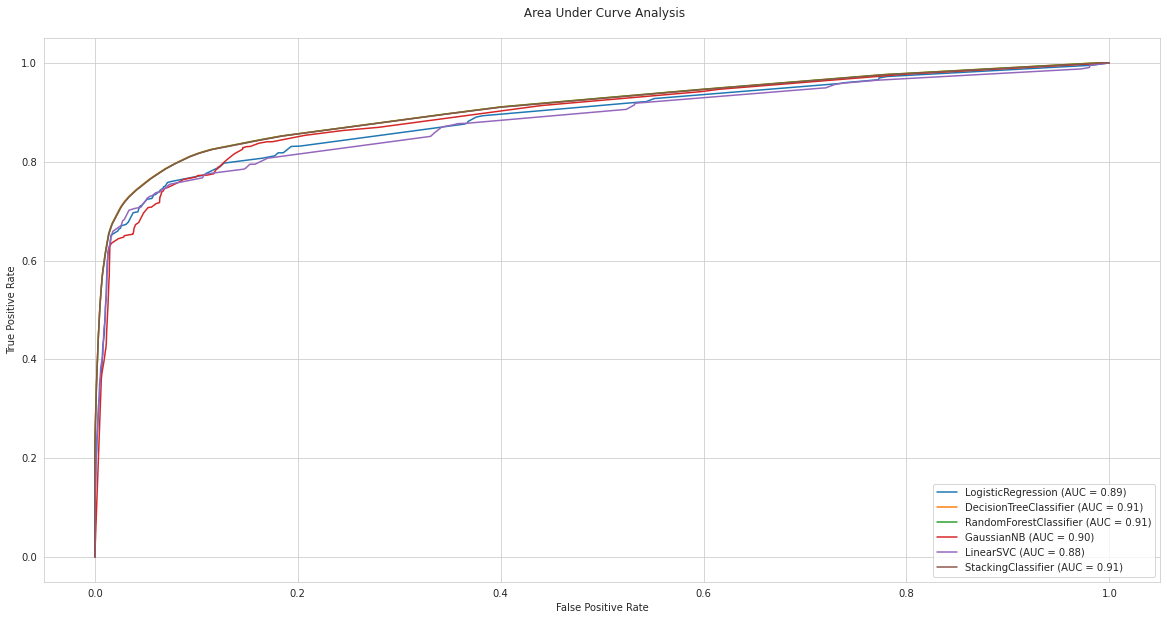

In [243]:
plt.rcParams["figure.figsize"] = [20,10]
X_test, Y_test = preprocess(test_data, encoder, lb)

disp = plot_roc_curve(lr,X_test,Y_test)
plt.title(' Area Under Curve Analysis\n')
plot_roc_curve(dt,X_test,Y_test,ax=disp.ax_)
plot_roc_curve(rfc,X_test,Y_test,ax=disp.ax_)
plot_roc_curve(gnb,X_test,Y_test,ax=disp.ax_)
plot_roc_curve(svr,X_test,Y_test,ax=disp.ax_)
plot_roc_curve(model,X_test,Y_test,ax=disp.ax_)

print("MODEL:",type(lr).__name__)
print("AUC ROC score for the model:", evaluate(lr, X_test, Y_test), "\n")
print("MODEL:",type(dt).__name__)
print("AUC ROC score for the model:", evaluate(dt, X_test, Y_test), "\n")
print("MODEL:",type(rfc).__name__)
print("AUC ROC score for the model:", evaluate(rfc, X_test, Y_test), "\n")
print("MODEL:",type(gnb).__name__)
print("AUC ROC score for the model:", evaluate(gnb, X_test, Y_test), "\n")
print("MODEL:",type(svr).__name__)
#print("AUC ROC score for the model:", evaluate(svr, X_test, X_test), "\n")
print("MODEL:",type(nn).__name__)
print("AUC ROC score for the model:", evaluate(nn, X_test, Y_test), "\n")

Hyperparameter search can become messy if you have lots of paramters. 
A brute force method to do such a search will be to do a grid search to fit tons of models. 
Thus, a smarter way to do hyperparameter search has been the subject of research. 

**TRY:** If interested, read [here](https://scikit-learn.org/stable/modules/grid_search.html) for more details and incorporate some of those ideas in the model building process. 

In [238]:
def get_stacking(models):
  # define the base models
  level0 = list()
  for m in models:
    level0.append((type(m).__name__, m))
#	level0.append(('knn', KNeighborsClassifier()))
#	level0.append(('rfc', RandomForestClassifier(min_samples_leaf=4, n_estimators=200, n_jobs=-1, random_state=909)))
#	level0.append(('dtc', DecisionTreeClassifier()))
#	level0.append(('svm', SVC()))
#	level0.append(('bayes', GaussianNB()))
#	level0.append(('lr', LogisticRegression()))
  
	# define meta learner model
  level1 = LogisticRegression(solver='liblinear')
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

def print_report(model, y_valid, y_valid_pred):
    print("Report for", model)
    print(classification_report(y_valid, y_valid_pred))
    print("="*20)
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_valid_pred, y_valid))

model = get_stacking([rfc,dt,nn])

model.fit(X_train, Y_train.ravel())

print(model.score(X_train, Y_train.ravel()))
y_pred = model.predict(X_test)
                      


Training interrupted by user.
Training interrupted by user.
Training interrupted by user.
Training interrupted by user.


0.96990471341286


In [239]:
print_report(model, model.predict(X_train), Y_train)
print_report(model, model.predict(X_valid), Y_valid)
print_report(model, model.predict(X_test), Y_test)

print("AUC ROC score for the model:", evaluate(model, X_test, Y_test), "\n")

Report for StackingClassifier(cv=5,
                   estimators=[('RandomForestClassifier',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='entropy',
                                                       max_depth=12,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
        

# Report your results

**NOTE:** You should use the test dataset only when you are done with hyperparameter search on your model. 
This is because the test dataset is not involved in the model building process, thereby making sure that the performance evaluation on the test dataset measures how well the proposed model is able to generalize.

AUC-ROC on the test dataset:0.909207402146918


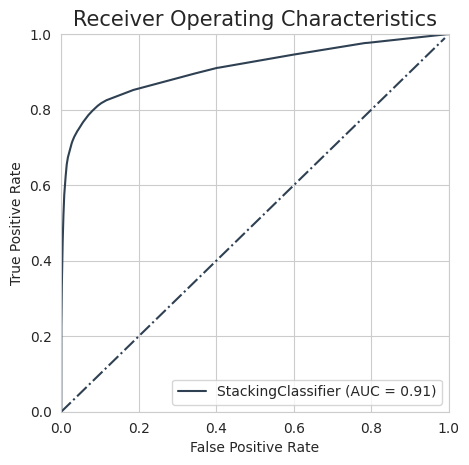

In [240]:
best_model = model

X_test, Y_test = preprocess(test_data, encoder, lb)
auc_score = evaluate(best_model, X_test, Y_test)
print(f"AUC-ROC on the test dataset:{auc_score}")
plot_ROC(best_model, X_test, Y_test)

Is this the end?

What do you need to do to make the model practically applicable? How would you use this model in the real life?

# Collaborate with Ensemble 

You can combine various models to form an ensemble model. 
There are various ways to combine these models. 
All of them serve a particular purpose (e.g. reducing variance, increasing accuracy. etc.). 

The simplest example of an ensemble is to combine the constituent models via voting. This can be done in two ways:
*  soft voting - likelihood of the input belonging to a class is the mean of the likelihood predicted by the constituent models, 
*  hard-voting - likelihood of the input belonging to a class is determined by frequency of the constutuent models predicting that class for the input.

Thus, if you are working in a team, let each member try out different models. At the end, combine your models and make an ensemble model. 

Here is the [User Guide](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) and [API](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) for making such an ensemble model.

# Extras: Class imbalance

**TRY:** 
 Why not try resampling techniques to optimize for ROC AUC?





# Extras: Dimensionality Reduction

**TRY:** You can try dimensionality reduction from 16 dimensions to just 2 dimensions and visualize 2D plot with just two categories - "positive" and "negative". 
To do this, try various dimension reduction techniques, for example, [LDA](https://scikit-learn.org/stable/modules/lda_qda.html#mathematical-formulation-of-lda-dimensionality-reduction), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA), [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 


# Poster template 

It is often the most difficult task to communicate the project's finding concisely in 1 minute or in a 1 slide. 
Therefore, our suggestion will be to touch upon the following points in your poster -  

1. Briefly define the problem
2. Briefly describe the dataset 
3. What did you learn about various models/techniques/etc.? e.g. 
4. What's the auc score of your final model did you get?

If you want to learn what matters in building such posters, check out this great [YouTube video](https://www.youtube.com/watch?v=1RwJbhkCA58).
Specifically, we should try and avoid posters with a lot of stuff to avoid cognitive overload. 
The templates suggested in the video can be found [here](https://osf.io/ef53g/). 
Note these are for academic papers, however, you can follow a similar ideology to concizsely display your work. 